# Surviving the Titanic: Exploring a Tragic Voyage

In [151]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [152]:
#Data Loading
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
GS = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## EDA ( Exploratory Data Analisys)

In [153]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Available features

- **PassengerId** - Passenger ID - Number
- **Survived** - Survived - Bool
- **Pclass** - Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd - Number
- **Name** - First name, Last Name and optional Title - String
- **Sex** - Sex of passenger - available: male and female - String
- **Age** - Age in years - Number
- **SibSp** - of siblings / spouses aboard the Titanic - Number
- **Parch** - of parents / children aboard the Titanic - Number
- **Ticket** - Ticket Id - String
- **Fare** - Passenger fare / Ticker price - Number
- **Cabin** - Cabin number - String
- **Embarked** - Port of Embarkation - available C = Cherbourg, Q = Queenstown, S = Southampton - String

### Feature Notes

- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5


In [154]:
rows_in_training_data = df_train.shape[0]
rows_in_testing_data = df_test.shape[0]

print(f'Rows in training data: {rows_in_training_data}.')
print(f'Rows in testing data: {rows_in_testing_data}.')
print(f'Total data: {rows_in_training_data + rows_in_testing_data}')

Rows in training data: 891.
Rows in testing data: 418.
Total data: 1309


### How many values are null?

#### Train set null values

In [155]:
# Searching for missing values

null_columns = df_train.columns[df_train.isnull().any()]
print(df_train[null_columns].isnull().sum())

Age         177
Cabin       687
Embarked      2
dtype: int64


#### Test set null values

In [156]:
null_columns = df_test.columns[df_test.isnull().any()]
print(df_test[null_columns].isnull().sum())

Age       86
Fare       1
Cabin    327
dtype: int64


## Data analysis and visualization

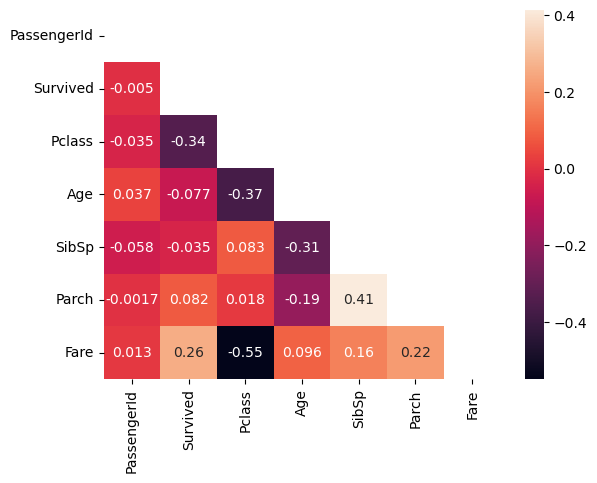

In [157]:
train_corr = df_train.corr()
mask = np.triu(np.ones_like(train_corr, dtype=bool))
sns.heatmap(data=train_corr,annot=True, mask=mask)
plt.show()

Based on this correlation matrix of the Titanic survivors, we can conclude the following:

- There is a **positive correlation** between **survival** and **being female (Sex)**, with a correlation coefficient of 0.54. This suggests that women were more likely to survive the sinking of the Titanic than men.

- There is a **negative correlation** between **survival** and **socio-economic status (Pclass)**, with a correlation coefficient of -0.34. This suggests that passengers in higher classes were more likely to survive than those in lower classes.

Overall, this correlation matrix provides insights into the factors that influenced survival rates during the Titanic disaster. It suggests that gender, socio-economic status, and age were the most significant factors influencing survival, while family size had a weaker influence.

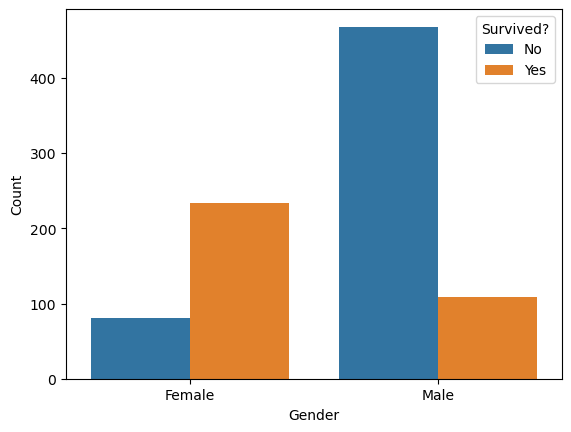

In [158]:
#Survivor count for males and females in the Titanic

grouped_data = df_train.groupby(['Sex', 'Survived']).size().reset_index(name='Count')
fig,ax = plt.subplots()
labels=["No","Yes"]
sns.barplot(x='Sex', y='Count', hue='Survived', data=grouped_data)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Survived?")
plt.xlabel("Gender")
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

The previous graph confirms the trend observed in the correlation matrix. Specifically, it shows that among the passengers on the Titanic, the majority in terms of both total number and percentage were female. This information aligns with previous findings suggesting that gender was a significant factor in determining survival rates during the tragic event.

In [159]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


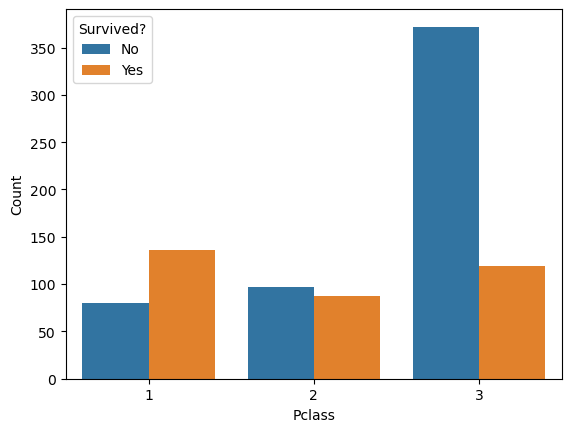

In [160]:
grouped_data = df_train.groupby(['Pclass', 'Survived']).size().reset_index(name='Count')
fig,ax = plt.subplots()
labels=["No","Yes"]
sns.barplot(x='Pclass', y='Count', hue='Survived', data=grouped_data)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Survived?")
plt.show()

We can see that among first-class passengers, there were more survivors (136) than non-survivors (80), while among second-class passengers, there were fewer survivors (87) than non-survivors (97). The largest number of non-survivors (372) came from the third-class passengers, while the third-class passengers also had the smallest number of survivors (119). So, we can conclude that the higher the passenger class (Pclass), the greater the chances of survival.

## Data Cleaning
---

To make sense of the data, we need to clean it up first. This involves removing irrelevant information, filling in missing data, and converting some data to a more useful format. For example, we **remove** data such as the **passenger's name**, **cabin number**, and **ticket number**, which are not relevant to our analysis. We also **fill in missing data** for the **passenger's age** with the average age of all passengers.

In [161]:
#Data Cleaning
def dropCols(df):
    df.drop(['PassengerId','Name','Ticket','Cabin'],axis='columns',inplace=True)
    return df

def dataCleaning(df):
    df["Age"].fillna(df["Age"].mean(),inplace= True)
    df["Fare"].fillna(df["Fare"].median(),inplace= True)
    df["Embarked"].fillna(df["Embarked"].mode(),inplace= True)
    
    
    df = pd.get_dummies(df, columns=['Pclass'], drop_first = True)
    df = pd.get_dummies(df, columns=['Sex'], drop_first = True)
    df = pd.get_dummies(df, columns=['Embarked'], drop_first = True)
    return df
    
df_train_cleaned = dataCleaning(df_train.copy())
df_test_cleaned  = dataCleaning(df_test.copy())
df_train_cleaned = dropCols(df_train_cleaned)
df_test_cleaned  = dropCols(df_test_cleaned)

X_train = df_train_cleaned.drop('Survived',axis='columns')
y_train = df_train_cleaned.Survived

X_train, X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = .2)

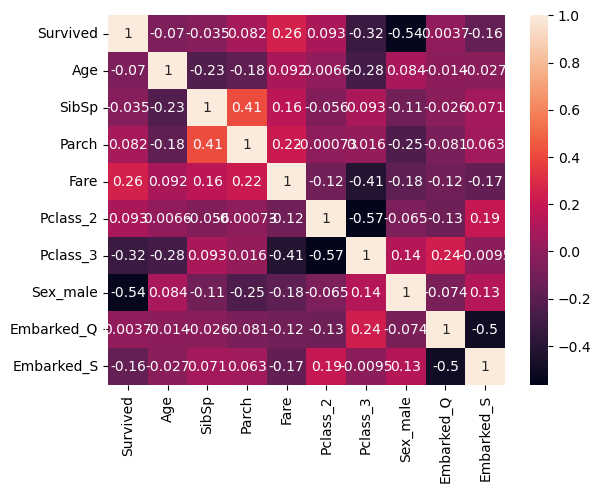

In [162]:
train_corr = df_train_cleaned.corr()
#mask = np.triu(np.ones_like(train_corr, dtype=bool))
sns.heatmap(data=train_corr,annot=True)
plt.show()

In [163]:
discrete_features = X_train.dtypes == int
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Sex_male      0.153679
Fare          0.103502
Pclass_3      0.081780
SibSp         0.026263
Embarked_S    0.023538
Parch         0.023462
Pclass_2      0.014451
Age           0.006184
Embarked_Q    0.000000
Name: MI Scores, dtype: float64

In [164]:
std_scaler = StandardScaler()
cols = ['Fare','Parch','SibSp','Age']

## Logistic Regression model

In [165]:
# Crear un objeto de regresión logística
lr = LogisticRegression()

# Crear un objeto de búsqueda de cuadrícula
param_grid = {'C': [.001, .01, .1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
             'max_iter':[6000]}

grid_search = GridSearchCV(lr, param_grid, cv=5)

# Ajustar el modelo a los datos de entrenamiento utilizando la búsqueda de cuadrícula
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la mejor puntuación del modelo
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

Mejores hiperparámetros: {'C': 1, 'max_iter': 6000, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación: 0.8076824583866837


In [166]:
y_pred = grid_search.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8044692737430168


In [167]:
predictions = grid_search.predict(df_test_cleaned)
result = pd.DataFrame({'PassengerId': df_test['PassengerId'],'Survived': predictions})

In [168]:
result.to_csv('submission.csv',index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
